In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from main import Net
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [10]:
### Data obtained from running main.py on different size datasets
train_acc = [99.647, 99.682, 99.537, 99.498, 99.529]
test_acc = [98.99, 98.78, 98.19, 97.6, 96.89]
ntot = 51005
n = np.array([1, 1/2, 1/4, 1/8, 1/16])*ntot

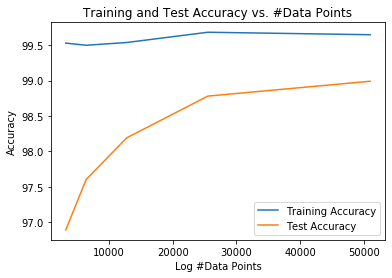

In [15]:
plt.plot(n, train_acc, label='Training Accuracy')
plt.plot(n, test_acc, label='Test Accuracy')
plt.legend()
plt.xlabel('Log #Data Points')
plt.ylabel('Log Accuracy')
plt.title('Training and Test Accuracy vs. #Data Points')
plt.show()

In [2]:
model = Net()
model.load_state_dict(torch.load('mnist_model.pt'))

<All keys matched successfully>

In [3]:
test_dataset = datasets.MNIST('../data', train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False)

In [11]:
misclassified = []
misclassified_labels = []
y_pred = torch.tensor([], dtype=int)
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        y_pred = torch.cat([y_pred, torch.flatten(pred)])
        incorrect = pred != target.view_as(pred)
        if (incorrect.sum().item() == 0):
            continue
        incorrect_ind = torch.where(incorrect)[0]
        incorrect_images = data[incorrect_ind]
        for i, img in enumerate(incorrect_images):
            misclassified.append(img[0])
            misclassified_labels.append([target[incorrect_ind[i]], pred[incorrect_ind[i]]])
            
print(len(misclassified))

82


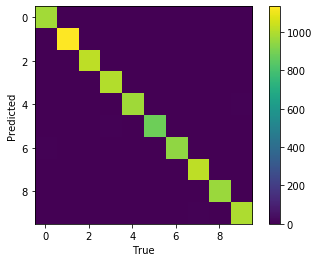

In [26]:
# Plot confusion matrix
plt.imshow(confusion_matrix(test_dataset.targets, y_pred))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.colorbar()
plt.show()

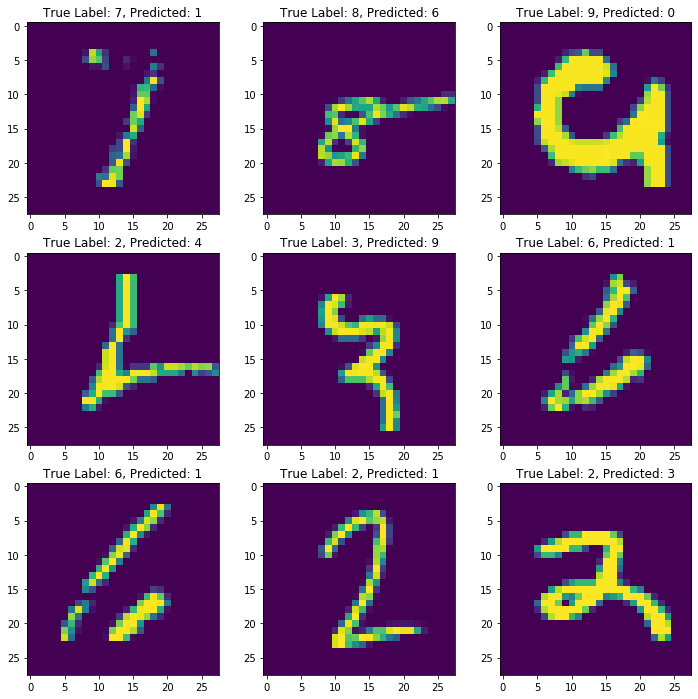

In [82]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
    ax[i // 3, i % 3].imshow(misclassified[i])
    ax[i // 3, i % 3].set_title(f'True Label: {misclassified_labels[i][0].item()}, Predicted: {misclassified_labels[i][1].item()}')

plt.show()

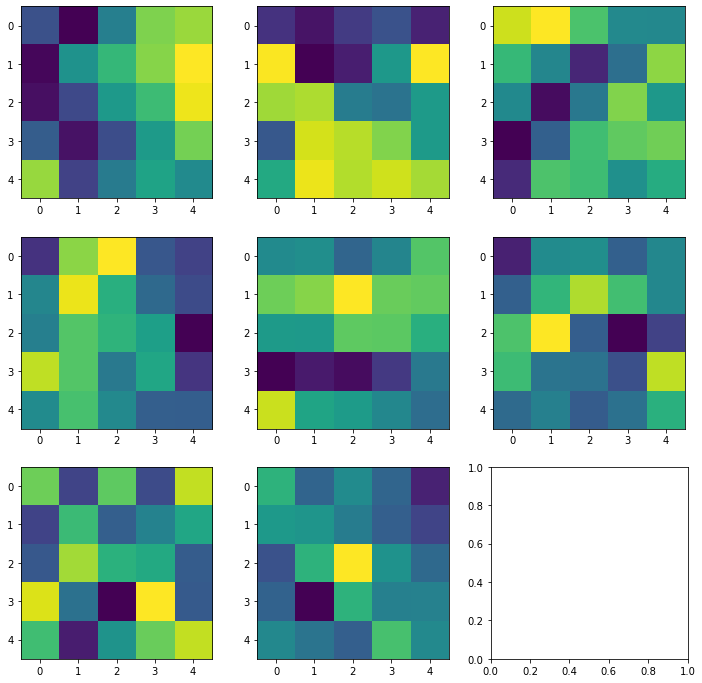

In [100]:
kernels = model.conv1.weight.data
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(len(kernels)):
    ax[i // 3, i % 3].imshow(kernels[i][0])

plt.show()

In [129]:
feature = []
def get_feature():
    def hook(model, input_, output):
        feature.append(output.detach())
    return hook
model.fc1.register_forward_hook(get_feature())

In [150]:
##tSNE visualization
feature = []
true_output = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        true_output.append(target)
        
features = torch.cat(feature)      
true_output = torch.cat(true_output)

In [151]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.114s...
[t-SNE] Computed neighbors for 10000 samples in 5.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.884097
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.622787
[t-SNE] KL divergence after 1000 iterations: 1.486037


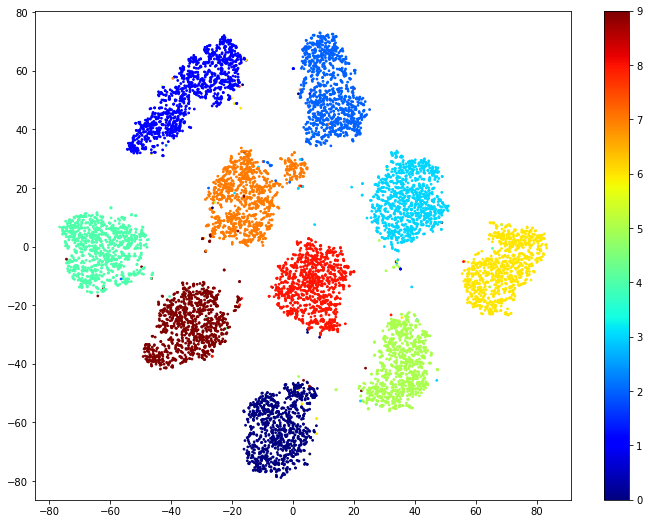

In [163]:
plt.figure(figsize=(12, 9))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=true_output, s=3, cmap='jet')
plt.colorbar()
plt.show()

In [207]:
representatives = range(4)

imgs = {}

for r in representatives:
    x = features[r]
    euclidean_distance = ((features - x)**2).sum(dim=1).sqrt()
    a = torch.argsort(euclidean_distance)
    closest_ind = a[1:9]
    closest_images = []
    for i in closest_ind:
        closest_images.append(test_dataset[i])
    imgs[r] = closest_images

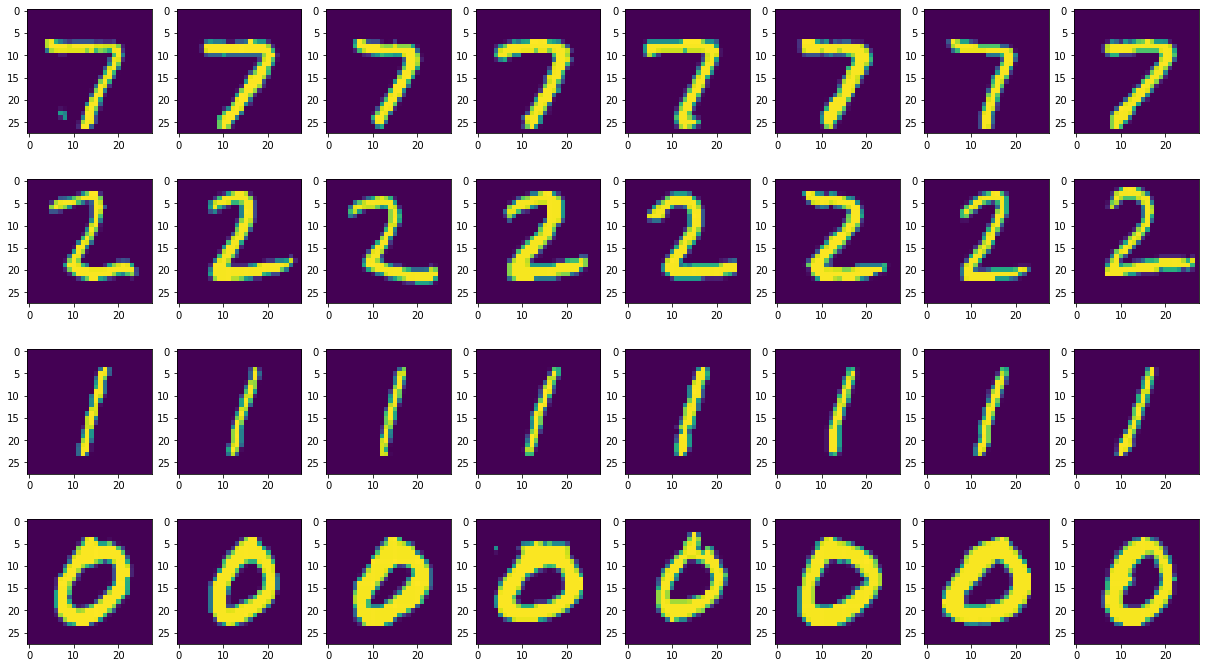

In [217]:
fig, ax = plt.subplots(4, 8, figsize=(21, 12))
for i in range(32):
    ax[i // 8, i % 8].imshow(imgs[i // 8][i % 8][0][0])
plt.show()